# Layered Model Assignment

## Model Description 
This is a steady state box model with recharge

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Topography
- Land surface 100m above the datum on the left hand side
- sloping linearly to 85m above the datum on the right hand side

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Left boundary constat head 85m
 - Right boundary is a constant head of 75 m 
 - Recharge occurs at a rate of 5E-5 m/d uniformly across the domain
 
#### Well: 
 - Pumping well
     - Located at (3000, 2500)
     - Puping at a rate of 800 m^3/day 

#### Recharge and ET
- Zone 1: (4000,0) bottom left and (5000,5000) upper right ET=1e-3 extinction depth 10 m and Recharge=1e-4
- Zone 2: (2250,3500) bottom left and (2750,4000) upper right Recharge=1E-3

#### Layered Scenario
 - Low K layer - Kx=Ky=Kz=0.00001m/d
 - Extending form 40-50m above the base of the domain
 - The well is only completed in the lowest layer
     

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Setup the input variables that are constant across scenarios

In [2]:
## Discritization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 1
dx= 10 #width of grid cells in x diretion 
dy= 10 #width of grid cells in y diretion 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('top_elev.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
ztop[0,0] = 100.                                           # insert missing initial value (not sure why didn't import)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation
dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_horiz = 1    #horizontal hydraulic conductivity 
K_vert = .1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined
K_confined= 100

#well
pumping = 2500 #m3/day  *This rate was figured out from the Water balance of the ET scenario
well_xy= [2500, 2500] #xy location of well 
well_row = np.floor((nrow-1)-(well_xy[1]/dy)) #convert the y location to a row
well_col = np.floor(well_xy[0]/dx-1) #convert the x location to a column
well_loc1 = (0,well_row,well_col) #Well loc shoudl be layer, row, column - in top layer for 1 layer model
well_loc3 = (2,well_row,well_col) #Well loc shoudl be layer, row, column - in bototm layer for 3 layer model 

print(well_loc1)
print(well_loc3)

#Zone one properties
#z1_recharge=0
#z1_ET=0
#z1_ETdepth=10
#z1_llxy=[4000,0]  #xy coordinates of lower left corner
#z1_urxy=[5000,5000] #xy coordiantes of upper right corner
#convert to rows and columns
#z1_rowll = int(np.floor((nrow-1)-(z1_llxy[1]/dy))) #convert the y location to a row
#z1_colll=int(np.floor(z1_llxy[0]/dx)-1)          #convert the x location to a column
#z1_rowur = int(np.floor((nrow-1)-(z1_urxy[1]/dy-1))) #convert the y location to a row
#z1_colur=int(np.floor(z1_urxy[0]/dx)-1)          #convert the x location to a column
#print(z1_colll, z1_rowll, z1_colur, z1_rowur)

#Zone two properties
z2_recharge=1e-4
z2_llxy=[1000,1000]  #xy coordinates of lower left corner
z2_urxy=[1500,2000] #xy coordiantes of upper right corner
#convert to rows and columns
z2_rowll = int(np.floor((nrow-1)-(z2_llxy[1]/dy))) #convert the y location to a row
z2_colll=int(np.floor(z2_llxy[0]/dx)-1)          #convert the x location to a column
z2_rowur = int(np.floor((nrow-1)-(z2_urxy[1]/dy))) #convert the y location to a row
z2_colur=int(np.floor(z2_urxy[0]/dx)-1)          #convert the x location to a column
print(z2_colll, z2_rowll, z2_colur, z2_rowur)

#print(z1_llxy[1])

## Recharge
#NOTE - Recharge applies to the top so this is always 1 layer input even when them model has more layers
R_zones = np.zeros((1,nrow,ncol))                             # define an array of zeros the size of the model grid
#R_zones[0,:, z1_colll:z1_colur] = z1_recharge     # assign recharge value 1 to the coordinates for zone 1 
R_zones[0,z2_rowur:z2_rowll, z2_colll:z2_colur] = z2_recharge      # assign recharge value  2 to coordinates for zone 2


###ET:
#NOTE - ET applies to the top so this is always 1 layer input even when them model has more layers
#ET_zones = np.zeros((1,nrow,ncol))                             # define an array of zeros the size of the model grid
#ET_zones[0,:, z1_colll:z1_colur] = z1_ET     # assign ET value 1 to the coordinates for zone 1 


## Boundary conditions
h_left = 90
h_right = 85

(0, 24.0, 24.0)
(2, 24.0, 24.0)
9 39 14 29


## 3. Setup and run MODFLOW for the one layer scenario 

In [3]:
#Initialize the model
modelname1 = "OneLayer"
moddir=r"C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mf2005.exe"
m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=R_zones, ipakcb=53)     #create rch object

#ET:
#evt = flopy.modflow.mfevt.ModflowEvt(m1, surf=ztop, evtr=ET_zones, exdp=z1_ETdepth, ipakcb=53) 

#Well
well_1 = [i for i in well_loc1] + [-pumping]
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]}
wel = flopy.modflow.ModflowWel(model=m1, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)

#write the inputs
m1.write_input()    

#Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


Well 1 [layer, row, column, flux]: 
 [0, 24.0, 24.0, -2500]
FloPy is using the following  executable to run the model: C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: OneLayer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/27 18:47:51

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/03/27 18:47:51
 Elapsed run time:  0.155 Seconds

  Normal termination of simulation


## 4. Setup and run MODFLOW for the three layer scenario 

In [4]:
#Initialize the model
modelname3 = "ThreeLayer"
moddir2=r"C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mf2005.exe"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir2)

## Make some changes to the parameters
nlay2=3  #two layers instead of 1
botm = np.zeros((nlay2,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                 # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 60.                 # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,:] = K_confined            #Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,:] = K_confined            #Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay2, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay2, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay2, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=R_zones, ipakcb=53)     #create rch object

#ET:
#evt = flopy.modflow.mfevt.ModflowEvt(m3, surf=ztop, evtr=ET_zones, exdp=z1_ETdepth, ipakcb=53) 

#Well
well_3 = [i for i in well_loc3] + [-pumping]
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_3]}
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=wel_spd)


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)

#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

Well 1 [layer, row, column, flux]: 
 [0, 24.0, 24.0, -2500]
FloPy is using the following  executable to run the model: C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\hws-PortilloD\Assignment\HW8 ReverseMidterm\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: ThreeLayer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/27 18:47:52

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/03/27 18:47:52
 Elapsed run time:  0.163 Seconds

  Normal termination of simulation


# 5. Plot the domains

### Plan view of the domain

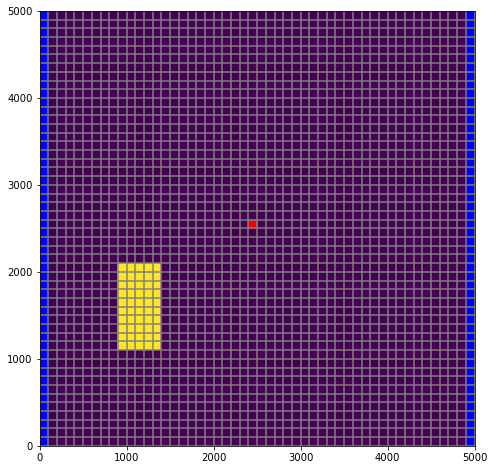

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m1)
quadmesh = mapview.plot_array(R_zones) # shows recharge zones 
ibound = mapview.plot_ibound()
wel = mapview.plot_bc("WEL")

linecollection = mapview.plot_grid()


### Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

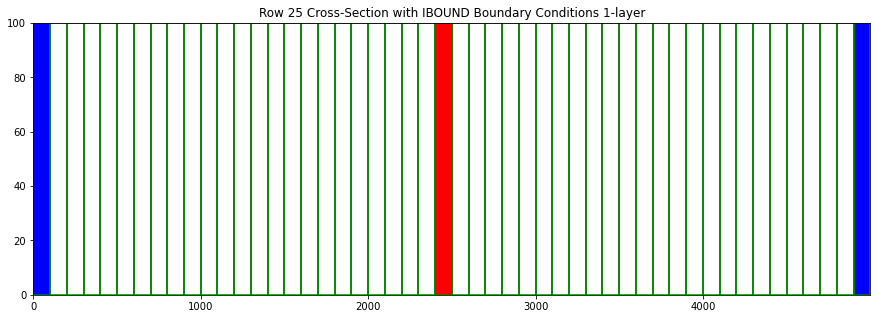

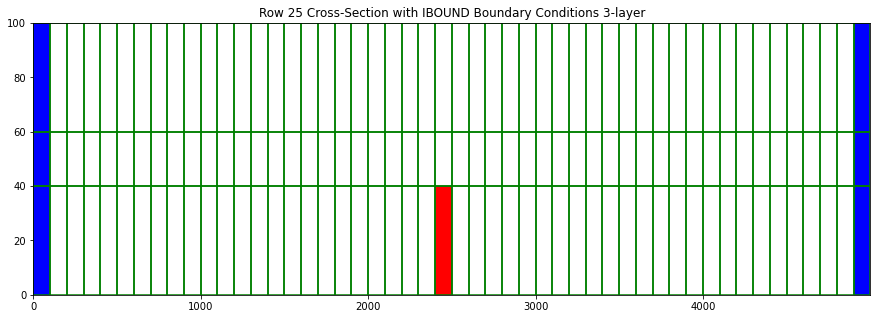

In [6]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions 1-layer')

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions 3-layer')

# 5. Add particles to both scenarios


In [7]:
moddirmp=r"C:\Users\Quilson2\OneDrive\Desktop\modpath_7_2_001\modpath_7_2_001\bin\mpath7"

#### Run the 1 layer scenario

In [8]:
#Make a group of particles - note we can use these for both simulations
#Just adding to the recharge zone

locsb = [[0, z2_rowur, z2_colll, 0, z2_rowll, z2_colur]] #Set the range of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
print(locsb)
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=3, rowcelldivisions=3, layercelldivisions=3) #Number of part per cell
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb]) #setup theparticles
pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg1]

defaultiface = {'RECHARGE': 6, 'ET': 6}


mpname1=os.path.join(modelname1 + '_mp')
print(mpname1)
mp1 = flopy.modpath.Modpath7(modelname=modelname1 + '_mp', flowmodel=m1, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp1, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp1, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)


mp1.add_package(rch)
mp1.write_input()
mp1.run_model()
mp1.get_package_list()

[[0, 29, 9, 0, 39, 14]]
OneLayer_mp
FloPy is using the following  executable to run the model: C:\Users\Quilson2\OneDrive\Desktop\modpath_7_2_001\modpath_7_2_001\bin\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      1782 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal t

['MPBAS', 'MPSIM', 'RCH']

#### Run the 3 layer scenario

In [9]:
locsb = [[0, z2_rowur, z2_colll, 0, z2_rowll, z2_colur]] #Set the range of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=3, rowcelldivisions=3, layercelldivisions=3) #Number of part per cell
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb]) #setup theparticles
pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg1]

defaultiface = {'RECHARGE': 6, 'ET': 6}

mpname3=os.path.join(modelname3 + '_mp')
print(mpname3)
mp3 = flopy.modpath.Modpath7(modelname=modelname3 + '_mp', flowmodel=m3, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp3, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp3, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)


mp3.add_package(rch)
mp3.write_input()
mp3.run_model()
mp3.get_package_list()

ThreeLayer_mp
FloPy is using the following  executable to run the model: C:\Users\Quilson2\OneDrive\Desktop\modpath_7_2_001\modpath_7_2_001\bin\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      1782 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.           

['MPBAS', 'MPSIM', 'RCH']

# 6. Read in the outputs

###  Modflow outputs - Heads and budget files

In [10]:
# Head - 1 layer model 
headobj1 = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times = headobj1.get_times()                #returns a list of timesteps
head1 = headobj1.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model 
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times = headobj3.get_times()                #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)


#Water balance - 1 layer
budgobj1 = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
print(budgobj1.get_unique_record_names())
kstpkper_list1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 


#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'        RECHARGE']
[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'        RECHARGE']
1


### Particle outputs 

In [11]:
### 1 layer model 
#Particle pathlines
fpth1 = os.path.join(mpname1 + '.mppth')
p1 = flopy.utils.PathlineFile(fpth1)

#Particle endpoints
fpth1 = os.path.join(mpname1 + '.mpend')
e1 = flopy.utils.EndpointFile(fpth1, verbose=False)

#make a subset which is all the particles
pall1 = p1.get_alldata()  
eall1 = e1.get_alldata()
        
#make a subset which is particles ending in the well
nodewell = m1.dis.get_node([(0,well_row, well_col)])
print(nodewell)
pwell1 = p1.get_destination_pathline_data(dest_cells=nodewell)
ewell1 = e1.get_destination_endpoint_data(dest_cells=nodewell)


### 3 layer model 
#Particle pathlines
fpth3 = os.path.join(mpname3 + '.mppth')
p3 = flopy.utils.PathlineFile(fpth3)

#Particle endpoints
fpth3 = os.path.join(mpname3 + '.mpend')
e3 = flopy.utils.EndpointFile(fpth3, verbose=False)

#make a subset which is all the particles
pall3 = p3.get_alldata()  
eall3 = e3.get_alldata()
        
#make a subset which is particles ending in the well
nodewell3 = m3.dis.get_node([(2,well_row, well_col)])
print(nodewell3)
pwell3 = p3.get_destination_pathline_data(dest_cells=nodewell3)
ewell3 = e3.get_destination_endpoint_data(dest_cells=nodewell3)

[1224]
[6224]


# 6. Plotting
#### Cross section plots

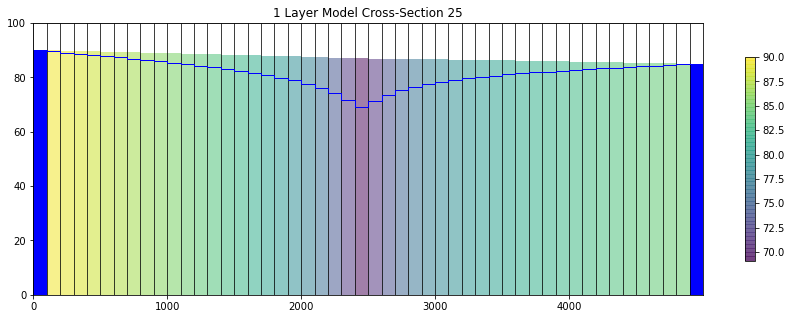

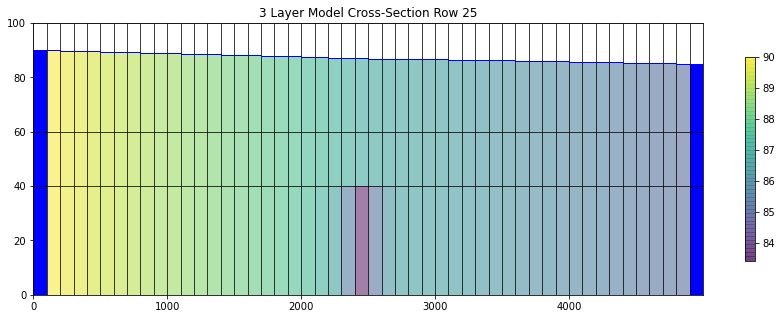

In [12]:
#### 1 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head1, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head1)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('1 Layer Model Cross-Section 25')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)


#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Cross-Section Row 25')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)


### Plot particle pathlines

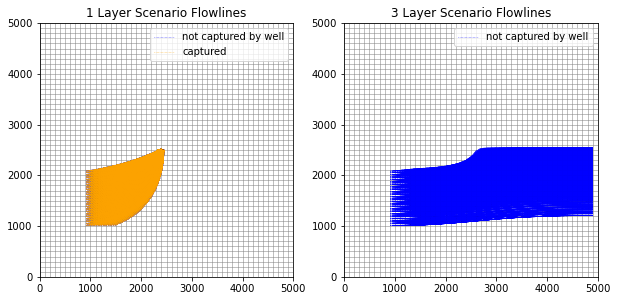

In [13]:
f, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

ax = axes[0]
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(1, 1, 1)

ax.set_aspect('equal')
ax.set_title('1 Layer Scenario Flowlines')
mm = flopy.plot.PlotMapView(model=m1, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall1, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by well') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pwell1, layer='all', color='orange', lw=0.5, linestyle=':', label='captured') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.ax.legend();

ax = axes[1]
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(1, 1, 1)

ax.set_aspect('equal')
ax.set_title('3 Layer Scenario Flowlines')
mm = flopy.plot.PlotMapView(model=m1, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall3, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by well') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pwell3, layer='all', color='orange', lw=0.5, linestyle=':', label='captured') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.ax.legend();

mm.plot_pathline(pwell3, layer='all', color='orange', lw=0.5, linestyle=':', label='3 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)

#plt.tight_layout();
#plt.savefig('Pathlines.png')

# Additional plots
### Plot head transect

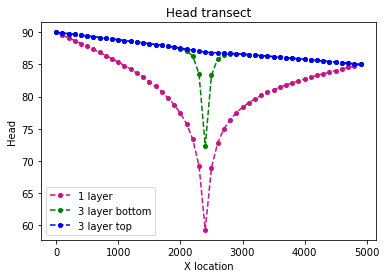

In [14]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,5000,100) 
plt.plot(x,head1[0,int(well_row),:],marker='o', color='mediumvioletred', markersize=4, linestyle='--', label="1 layer")
plt.plot(x,head3[2,int(well_row),:],marker='o', color='green', markersize=4, linestyle='--', label="3 layer bottom")
plt.plot(x,head3[0,int(well_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="3 layer top")
plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()
plt.savefig('Head_Transect.png')


###  1 Layer Head Contours

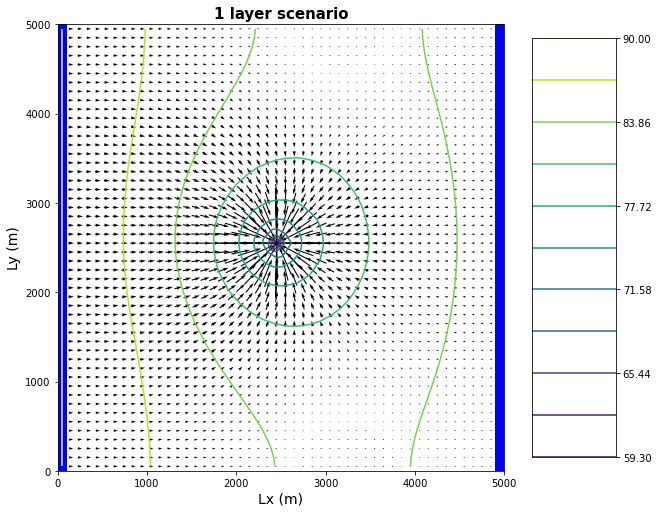

In [15]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m1, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

### 3 Layer head contours

[  0.          -0.45116884  -0.90467244  -1.3626275   -1.8267162
  -2.2980092   -2.7770202   -3.264601    -3.765548    -4.2990456
  -4.9158964   -5.6342654   -6.45572     -7.371693    -8.356177
  -9.348921   -10.31908    -11.247647   -12.11703    -12.907916
 -13.599317   -14.169971   -14.60032    -14.874632   -14.982937
 -14.922384   -14.697756   -14.321051   -13.810222   -13.187366
 -12.476692   -11.702623   -10.888207   -10.054006    -9.217431
  -8.392483    -7.5897985   -6.8169036   -6.078586    -5.3773093
  -4.713641    -4.0866394   -3.4941866   -2.9332838   -2.4002776
  -1.8910457   -1.4011403   -0.9258882   -0.46047437   0.        ]
[4.4977617 4.497102  4.4957104 4.4935374 4.490561  4.4867983 4.4823327
 4.47737   4.472242  4.467152  4.4614215 4.454179  4.4445496 4.4316354
 4.414707  4.393926  4.3695955 4.3419304 4.311093  4.2772717 4.240749
 4.2019267 4.1613417 4.1196465 4.077573  4.0358806 3.9952981 3.956471
 3.919922  3.8860285 3.8550208 3.8269937 3.8019285 3.7797194 3.760199
 

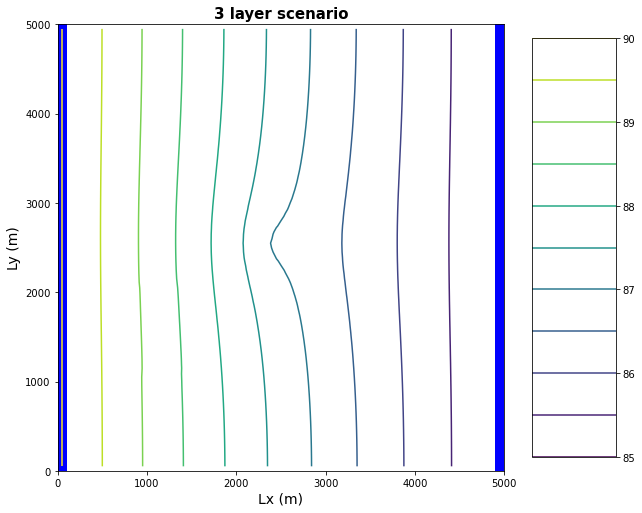

In [16]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
print(fff1[0][0][40])
print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
#flows = modelmap.plot_discharge(frf3[0][0], fff3[0][0], head=head3[0]) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   